# Skymap intuition via plotting

Note: this contains very early code that I used to build my own intuition for skymaps. As such, the code is fairly unpolished and does not make use of the converted skymaps, which would be a cool thing to do next in this notebook.

## Rings sky map pixelization
*From the RingsSkyMap docstring in lsst.skymap:*

We divide the sphere into N rings of Declination, plus the two polar
caps, which sets the size of the individual tracts.  The rings are
divided in RA into an integral number of tracts of this size; this
division is made at the Declination closest to zero so as to ensure
full overlap.

Rings are numbered in the rings from south to north. The south pole cap is
``tract=0``, then the tract at ``raStart`` in the southernmost ring is
``tract=1``. Numbering continues (in the positive RA direction) around that
ring and then continues in the same fashion with the next ring north, and
so on until all reaching the north pole cap, which is
``tract=len(skymap) - 1``.

However, ``version=0`` had a bug in the numbering of the tracts: the first
and last tracts in the first (southernmost) ring were identical, and the
first tract in the last (northernmost) ring was missing. When using
``version=0``, these tracts remain missing in order to preserve the
numbering scheme.

## Plots

In [3]:
from pathlib import Path
from skymap_convert import load_pickle_skymap

package_root = Path.home() / "skymap-convert"

raw_skymaps_dir = package_root / "tests" / "data" / "raw_skymaps"
raw_skymap_path = raw_skymaps_dir / "skyMap_lsst_cells_v1_skymaps.pickle"

In [4]:
lsst_skymap = load_pickle_skymap(raw_skymap_path)
lsst_skymap

### Molleweide ring and tract

todo : clean the following code a bit

In [8]:
def _get_ring_bounds(skymap, verbose=False):
    """Get the ring bounds for a skymap."""
    ring_bounds = []
    print(f"Getting bounds for {len(skymap._ringNums)} rings.")
    for i in range(skymap.config.numRings + 1):
        startDec = skymap._ringSize*(i + 0.5) - 0.5*math.pi
        stopDec = startDec + skymap._ringSize
        ring_bounds.append(startDec)

    if verbose:
        for i, b in enumerate(ring_bounds):
            if i % 10 == 0:
                print(f"Boundary {i}: {b:.2f} radians, {b * 180 / math.pi:.2f} degrees")
                
    return ring_bounds

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import math

def plot_skymap(skymap):
    """
    Plot the skymap using Mollweide projection.
    """
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection="mollweide")
    ax.grid(True)

    # Pick a ring.
    ring_index = 74
    ring_bounds = _get_ring_bounds(skymap, verbose=False)

    # Plot the ring boundaries.
    if 0 <= ring_index and ring_index < len(ring_bounds) - 1:
        boundary_upper = ring_bounds[ring_index]
        boundary_lower = ring_bounds[ring_index + 1]
        print(f"Ring {ring_index} bounds: {boundary_lower:.3f} to {boundary_upper:.3f} radians")
        ax.fill_betweenx(
            [boundary_lower, boundary_upper],
            -np.pi,
            np.pi,
            color="green",
            alpha=0.5,
            label=f"Ring {ring_index}"
        )

    # Pick a tract.
    tract_index = 54

    # Plot the tract boundaries.
    if 0 <= tract_index and tract_index < skymap._ringNums[ring_index]:
        print(f"Ring {ring_index} has {skymap._ringNums[ring_index]} tracts.")
        num_tracts = skymap._ringNums[ring_index]
        if tract_index >= num_tracts / 2:
            tract_index = tract_index - num_tracts  # Wrap around to negative RAs.
        ra_start = skymap.config.raStart + tract_index * (360 / num_tracts)
        ra_end = ra_start + (360 / num_tracts)
        print(f"Plotting tract {tract_index} in ring {ring_index}:")
        ax.fill_betweenx(
            [boundary_lower, boundary_upper],
            np.radians(ra_start),
            np.radians(ra_end),
            color="blue",
            alpha=0.5,
            linewidth=1,
            label=f"Tract {tract_index}"
        )
        # TODO - Look into edge cases for the wrapping of RA values. Picked this arbitrarily.

    # Draw the plot.
    ax.set_xlabel("Right Ascension (degrees)")
    ax.set_ylabel("Declination (degrees)")
    ax.set_title("Mollweide Projection of Skymap")
    ax.legend()
    plt.show()

Getting bounds for 120 rings.
Ring 74 bounds: 0.389 to 0.363 radians
Ring 74 has 227 tracts.
Plotting tract 54 in ring 74:


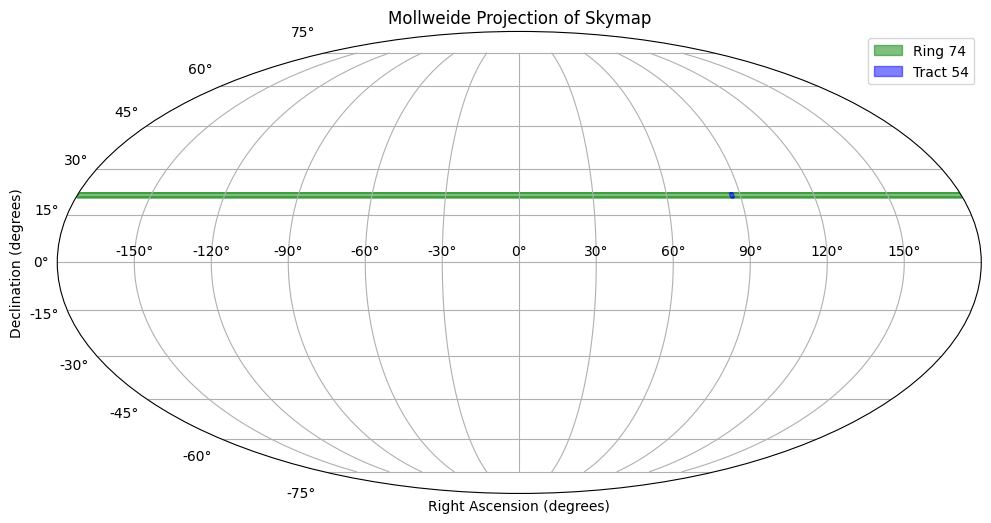

In [12]:
plot_skymap(lsst_skymap)

### Zoom to tract

In [ ]:
def plot_tract(skymap, ring_index, tract_index):
    """
    Plot a specific tract in a skymap.
    """

    ring_bounds = _get_ring_bounds(skymap, verbose=False)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.grid(True)

    # Plot the ring boundaries.
    if 0 <= ring_index < len(ring_bounds) - 1:
        boundary_lower = ring_bounds[ring_index]
        boundary_upper = ring_bounds[ring_index + 1]
        print(f"Ring {ring_index} bounds: {np.degrees(boundary_lower):.2f}° to {np.degrees(boundary_upper):.2f}° declination")

        ax.fill_betweenx(
            y=[np.degrees(boundary_lower), np.degrees(boundary_upper)],
            x1=-180,
            x2=180,
            color="green",
            alpha=0.5,
            label=f"Ring {ring_index}"
        )

        num_tracts = skymap._ringNums[ring_index]
        print(f"Ring {ring_index} has {num_tracts} tracts.")

        # Handle RA wraparound
        tract_index_wrapped = tract_index
        if tract_index_wrapped >= num_tracts / 2:
            tract_index_wrapped = tract_index_wrapped - num_tracts

        ra_start = skymap.config.raStart + tract_index_wrapped * (360 / num_tracts)
        ra_end = ra_start + (360 / num_tracts)

        print(f"Plotting tract {tract_index} in ring {ring_index}:")
        print(f"\tRA {ra_start:.2f}° to {ra_end:.2f}°")
        print(f"\tDec {np.degrees(boundary_lower):.2f}° to {np.degrees(boundary_upper):.2f}°")

        ax.fill_betweenx(
            y=[np.degrees(boundary_lower), np.degrees(boundary_upper)],
            x1=ra_start,
            x2=ra_end,
            color="blue",
            alpha=0.5,
            linewidth=1,
            label=f"Tract {tract_index}"
        )

        # Set zoomed-in limits
        margin = 2  # degrees
        ax.set_xlim(ra_start - margin, ra_end + margin)
        ax.set_ylim(np.degrees(boundary_lower) - margin, np.degrees(boundary_upper) + margin)

    # Draw the plot.
    ax.set_xlabel("Right Ascension (degrees)")
    ax.set_ylabel("Declination (degrees)")
    ax.set_title("Zoomed-In View of Selected Tract")
    ax.legend()
    plt.show()


Getting bounds for 120 rings.
Ring 74 bounds: 20.83° to 22.31° declination
Ring 74 has 227 tracts.
Plotting tract 54 in ring 74:
	RA 85.64° to 87.22°
	Dec 20.83° to 22.31°


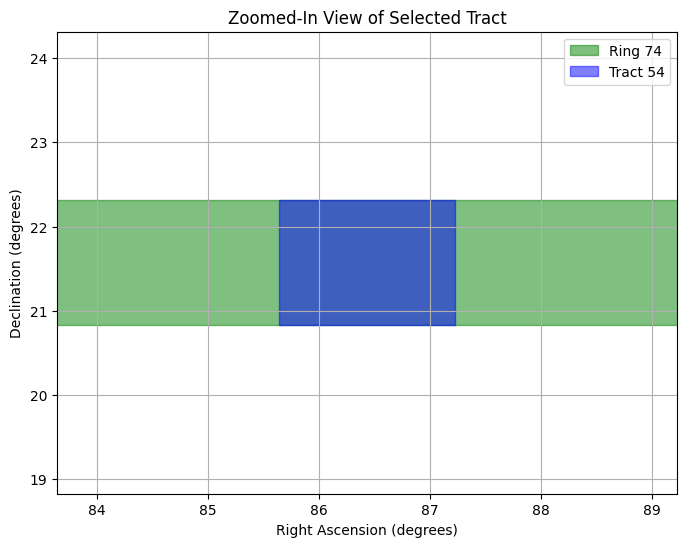

In [20]:
plot_tract(lsst_skymap, ring_index=74, tract_index=54)